# Filters and DTMF

Let us come back to the example of a two-tones signal. Such signal seems very simplistic, but it is the signal underlying a former signaling system known as Dual Tone Multi Frequency. The role of a signaling system in a telephone network is, among others, to setup a call, in particular by determining the number dialed by a user. The frequencies composing the signal correspond to the frequency of the column and the frequency of the row where the button lies in, as illustrated by the following table.
 <table>
  <tr>
    <td> </td>
    <td>1209 Hz</td>
    <td>1336 Hz</td>
    <td>1477 Hz</td>
  </tr>
  <tr>
    <td>697 Hz</td>
    <td>1</td>
    <td>2</td>
    <td>3</td>
  </tr>
  <tr>
    <td>770 Hz</td>
    <td>4</td>
    <td>5</td>
    <td>6</td>
  </tr>
  <tr>
    <td>852 Hz</td>
    <td>7</td>
    <td>8</td>
    <td>9</td>
  </tr>
  <tr>
    <td>941 Hz</td>
    <td>*</td>
    <td>0</td>
    <td>#</td>
  </tr>
</table> 

For example, upon pressing a $1$, the generated signal contains frequencies $1209$ Hz and $697$ Hz. We obtain the following continuous time signal:

$$x(t)=sin(2418πt)+sin(1394πt)$$.

Furthermore, the various frequencies were chosen such that none can be obtained as a result of simple operations of two others. This is meant to avoid interference.

The generated signal is transmitted over an analog transmission line to a switching center where the button that was pressed should be determined. This is done by analyzing the frequencies present in the signal. We have seen that this could be done by using Fourier analysis ($STFT$). This is however not the procedure that is used in DTMF, as it is computationally expensive. Instead, a filter bank is used, followed by a decoder.

The signal $x(t)$ is first sampled at a frequency $f_s$ so as to obtain the digital signal $x[n]$. The later is filtered by a series of $7$ passband filters placed in parallel. Each of them attenuates all frequencies except the one corresponding to one of the frequencies of DTMF $f_0$.

On the one hand, the frequency $f_0$ is a real-world, continuous frequency, expressed in Hz. On the other hand, the filters are digital and their frequency is a digital, unitless frequency $\omega_0$. The two are related by the relation

$\omega_0=2\pi \frac{f_0}{f_s}$.

Finally, a block called decoder outputs the digit depending on the energy of the signals placed at its input. We focus now on the design of one of the bandapass filters...

##IIR filter

One possibility consists of designing an IIR filter. In order to let only a certain frequency $\omega_0$ pass, the filter has a pole at the desired $\omega_0$. The filter also has a pole at $−\omega_0$, so as to obtain a real impulse response.

Since the poles are located on the unit circle, this filter is not stable! This can be a great problem in practice, as a small error can get amplified and lead to a decoding error. As a solution we can place instead the poles at $\lambda e^{j\omega_0}$ and $\lambda e^{-j\omega_0}$ with $0<\lambda<1$. 
The z-transform of the filter is then given by:

$$H(z) = \frac{1}{(1 - \lambda e^{j\omega_0} z^{-1})(1 - \lambda e^{-j \omega_0} z^{-1})}$$
$$H(z) = \frac{1}{1 - 2 \lambda cos(\omega_0) z^{-1} + \lambda^2 z^{-2} }$$

This filter is stable, as all the poles are located inside the unit circle. It is called a resonator. In the time-domain, given the input $x[n]$ the output of the filter $y[n]$ is then given by the following iterative formula:

$$y[n] = x[n] - 2\lambda cos(\omega_0) y[n-1] + \lambda^2 y[n-2]$$

In [1]:
#The filter is implemented using the following code.
def my_filter(x,b,a):
    # my_filter takes as inputs the numerator and denominator coefficients b and a, and the signal to filter x
    import numpy as np

    # Extract Parameters
    nx = len(x)
    nb = len(b) # order of numerator
    na = len(a) # order of denominator
    
    # Zero Padding (previous inputs and outputs)
    y = np.zeros(nx+na-1)
    x = np.append(np.zeros(nb -1),x)
    
    # Filter (in time domain, based on direct expresion)
    for N in range(nx):
        if na > 1:
            y[N+na-1] = -(a[na-1:0:-1]*y[N:N+na-1]).sum() + (b[::-1]*x[N:N+nb]).sum()
        else:
            y[N+na-1] = (b[::-1]*x[N:N+nb]).sum()
    
    # remove padding
    y = y[na:]
    
    return y

Previous code realizes the filter implementation in direct formula:

$$H(z) = \frac{\sum_{k=0}^{M-1} {b_k z^{-k}}}{1 + \sum_{k=1}^{N-1} {a_k z^{-k}}}$$

$$y[n] = \sum_{k=0}^{M-1} {b_k x[n-k]} - \sum_{k=1}^{N-1} {a_k y[n-k]}$$

In [3]:
# Now some test is carried out
%pylab inline # IMPORTANTE: importar pylab antes de scipy y numpy para evitar errores!
from scipy import fftpack as f
import numpy as np

F0 = 697.0     # corresponding to the first row of keys
FS = 2000.0    # sampling frequency
LAMBDA = 0.98

# Generate discrete-time signal x
n = np.linspace(0.0005,0.1,200)
x = np.sin(2*np.pi*697.0*n) + np.sin(2*np.pi*1209.0*n)  # "Key 1 pressed"

#Plot pole diagram of the filter
omega0 = 2*np.pi*F0/FS
pole_1 = np.exp(1j*omega0)
pole_2 = np.exp(-1j*omega0)

#Filter Signal
b = np.array([1.])
a = np.array([1., -2*np.cos(omega0)*LAMBDA**2, LAMBDA**2])

y1 = my_filter(x,b,a)

Populating the interactive namespace from numpy and matplotlib


Now plot the input signal, the filtered signal and the corresponding frequency diagrams

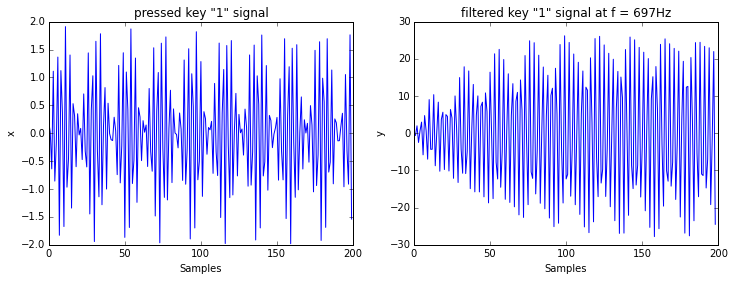

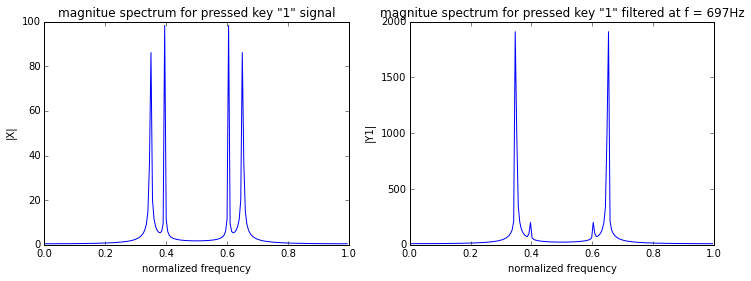

In [4]:
figure(num=None, figsize=(12,4), dpi=80, facecolor='w', edgecolor='k')
subplot(1,2,1)
plot(np.arange(x.size),x)
xlabel('Samples'), ylabel('x'), title('pressed key "1" signal')
subplot(1,2,2)
plot(np.arange(y1.size), y1)
xlabel('Samples'), ylabel('y'), title('filtered key "1" signal at f = 697Hz')
show()


#Let us look at the magnitude of the DFT/DFS of this signal
figure(num=None, figsize=(12,4), dpi=80, facecolor='w', edgecolor='k')
subplot(1,2,1)
plot(np.arange(x.size)/float(x.size), abs(f.fft(x)))
xlabel('normalized frequency'), ylabel('|X|'), title('magnitue spectrum for pressed key "1" signal')
subplot(1,2,2)
plot(np.arange(y1.size)/float(y1.size), abs(f.fft(y1)))
xlabel('normalized frequency'), ylabel('|Y1|'), title('magnitue spectrum for pressed key "1" filtered at f = 697Hz')
show()


This is exactly what we wanted, a filter that lets a certain frequency pass while attenuating other frequencies. Finally, let us count the number of operations to compute the output of the filter. Each iteration requires $2$ multiplications and $2$ additions, thus a total of $2N$ multiplications and $2N$ additions.

Instead of designing an $IIR$ filter, we could choose to design a $FIR$ filter. The Parks-McClellan algorithm is a standard procedure that finds the optimal $FIR$ filter given a set of specifications. Here optimal means that the resulting filter minimizes the weighted maximum error. To implement our filter, we can use the function http://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.signal.remez.html $scipy.signal.remez(...)$ which is part of the signal processing toolbox.

As before, we would like to design a bandpass filter, but this time we specify certain tolerance $d_s$ and $d_p$ in the stop band and pass band, respectively.

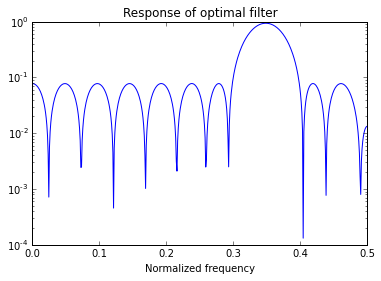

In [5]:
# scipy.signal.remez(numtaps, bands, desired, weight=None, Hz=1, type='bandpass', maxiter=25, grid_density=16)

# Parameters
F0 = 697.
FS = 2000.

# Generate discrete-time signal x
n = np.linspace(0.0005,0.1,200)
x = np.sin(2*np.pi*697* n) + np.sin(2*np.pi*1209*n)

# Parks-McClellan
numbands = 3
bands = (1./float(FS))*np.array([0, F0-100, F0-25, F0+25, F0+100, FS/2.])
df = bands[2] - bands[1]
des = np.array([0, 1, 0])
dp = 0.1
ds = 0.05
k = ds/dp
weight = np.array([1, k, 1])
griddensity = 16
numtaps = np.ceil(1-(10*np.log10(dp*ds)+13)/(2.324*2*np.pi*df)) + 1

from scipy import signal as sc

h = sc.remez(int(numtaps), bands, des, weight=weight, type='bandpass', grid_density=griddensity, maxiter=40)

# plot the frequency response of the filter
freq, response = sc.freqz(h)
ampl = np.abs(response)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.semilogy(freq/(2*np.pi), ampl, 'b-')  # freq in Hz
title('Response of optimal filter'), xlabel('Normalized frequency')
plt.show()

Applying the filter to the same input signal x, we obtain the following output

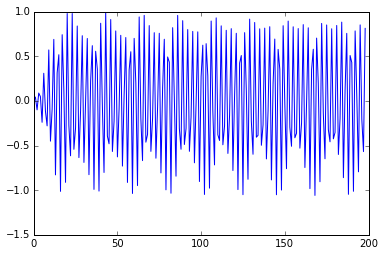

In [6]:
#zzz = my_filter(x, h[::-1], np.array([1.]))
y2 = my_filter(x, h, np.array([1.]))
plot(y2)
show()

where one tones has been attenuated, as illustrated by the norm of its Fourier transform

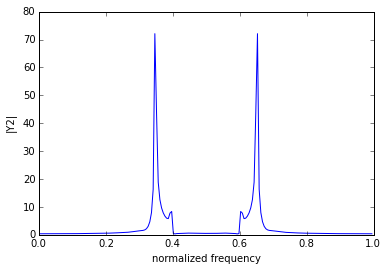

In [8]:
plot(np.arange(y2.size)/float(y2.size), abs(fft.fft(y2)))
xlabel('normalized frequency'), ylabel('|Y2|')
show()